# Adversarial attack in models of sequential data (ADA)


In [1]:
#Import models

from src.models import GenClass, CNN, Encoder, LSTMModel

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import math

In [3]:
def metrics(true, pred):
    true = np.array(true)
    pred = np.array(pred)
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred)
    ras = roc_auc_score(true, pred)

    return {
        'accuracy_score': acc,
        'f1_score': f1,
        'roc_auc_score': ras
    }
    

In [4]:
import numpy as np

def read_tsv(filename):
    data = np.loadtxt(filename, delimiter = "\t")
    y = data[:, 0]
    x = data[:, 1:]
    
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = read_tsv(root_url + "FordA_TRAIN.tsv")
x_test, y_test = read_tsv(root_url + "FordA_TEST.tsv")


In [5]:
x_test.shape

(1320, 500)

In [6]:
x_train.shape

(3601, 500)

In [7]:
classes = np.unique(np.concatenate((y_train, y_test)))
classes

array([-1,  1])

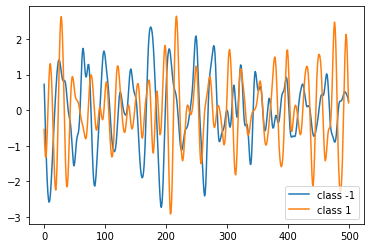

In [8]:
import matplotlib.pyplot as plt

i = 1

for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[i], label = "class " + str(c))
plt.legend(loc = "best")
plt.show()

In [9]:
idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

In [10]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

### Dataloader

In [12]:
from torch.utils.data import Dataset, DataLoader

class TrainData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index].unsqueeze(-1), self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


class TestData(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index].unsqueeze(-1)
        
    def __len__ (self):
        return len(self.X_data)

In [13]:
train_data = TrainData(torch.FloatTensor(x_train), torch.LongTensor(y_train))
test_data = TrainData(torch.FloatTensor(x_test), torch.LongTensor(y_test))

BATCH_SIZE = 128

train_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE)
test_loader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE)

In [18]:
def set_lr(optim, lr):
    for p in optim.param_groups:
        p['lr'] = lr
    print(f'Lr is adjusted to {lr}')

In [19]:
def cosine_annealing_lr(epoch, num_epochs, initial_lr):
    return initial_lr * 0.5 * (1 + math.cos(math.pi * epoch / num_epochs))

In [21]:
device = torch.device('cuda:0')

In [22]:
#define parameters
in_ch = 1
d_model = 64
features = [128, 256, 512] # for cnn
act_func = nn.GELU
kernel_size = 3
dilation = 1 # not change
num_layers = 3
dropout = 0.1
n_heads = 8

In [23]:
cnn = CNN(in_ch=d_model, out_ch=d_model, features=features, kernel_size=3, dilation=dilation, act_func=act_func)
lstm = LSTMModel(input_dim=d_model, embed_dim=d_model, num_layers=num_layers, dropout_prob=dropout)
encoder = Encoder(d_model=d_model, n_heads=n_heads, n_layers=num_layers,dropout=dropout)

In [24]:
model = GenClass(in_ch=in_ch, d_model=d_model, models=[cnn], num_classes=2).to(device)

In [25]:
n_epochs = 100
lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
loss_func = torch.nn.CrossEntropyLoss()

In [26]:
for epoch in tqdm(range(n_epochs)):
    model.train()
    train_tar = []
    train_pred = []
    epoch_train_loss = 0
    print('Training...')
    
    for batch_cat, batch_target in train_loader:
        
        batch_cat, batch_target = batch_cat.to(device), batch_target.to(device)
        
        optimizer.zero_grad()
        
        output = model(batch_cat)
        
        loss = loss_func(output, batch_target)
        
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()

        train_tar.extend(batch_target.cpu().tolist())
        train_pred.extend(output.detach().cpu().argmax(-1).tolist())

    print(f'Epoch {epoch+1} || Train loss {epoch_train_loss / len(train_loader.dataset)}')
    print(metrics(train_tar, train_pred))
    print('Validation...')
    with torch.no_grad():
        model.train(False)
        epoch_valid_loss = 0
        val_tar = []
        val_pred = []
        for batch_tuple in test_loader:
            (batch_cat, batch_target) = batch_tuple
            batch_cat, batch_target = batch_cat.to(device), batch_target.to(device)
            output = model(batch_cat)
            loss = loss_func(output, batch_target)
            epoch_valid_loss += loss.item()
            val_tar.extend(batch_target.cpu().tolist())
            val_pred.extend(output.detach().cpu().argmax(-1).tolist())

        print(f'Epoch {epoch+1} || Valid loss {epoch_valid_loss / len(test_loader.dataset)}')
        print(metrics(val_tar, val_pred))
    set_lr(optimizer, cosine_annealing_lr(epoch, n_epochs, lr))
    

  0%|          | 0/100 [00:00<?, ?it/s]

Training...
Epoch 1 || Train loss 0.009206999758487606
{'accuracy_score': 0.51985559566787, 'f1_score': 0.5058588168048014, 'roc_auc_score': 0.5194715300349103}
Validation...
Epoch 1 || Valid loss 0.005657029603466843
{'accuracy_score': 0.553030303030303, 'f1_score': 0.5058626465661641, 'roc_auc_score': 0.5505504884421556}
Lr is adjusted to 0.001
Training...
Epoch 2 || Train loss 0.004892660243350312
{'accuracy_score': 0.6328797556234379, 'f1_score': 0.6519220642443391, 'roc_auc_score': 0.6346675494562819}
Validation...
Epoch 2 || Valid loss 0.005242458934133703
{'accuracy_score': 0.6643939393939394, 'f1_score': 0.552072800808898, 'roc_auc_score': 0.6570805153978201}
Lr is adjusted to 0.0009997532801828658
Training...
Epoch 3 || Train loss 0.0038048380598430004
{'accuracy_score': 0.7475701194112746, 'f1_score': 0.7563655856338782, 'roc_auc_score': 0.7489607158621243}
Validation...
Epoch 3 || Valid loss 0.004879115702527942
{'accuracy_score': 0.65, 'f1_score': 0.437956204379562, 'roc_au

KeyboardInterrupt: 